In [1]:
import os
import glob
import random
import torch
import torchvision
import numpy as np
import cv2
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
from IPython.display import Image
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

device

'cuda'

## Датасет

Датасет состоит из изображений различных видов спорта. В датасете представлены 100 классов. Ссылка на датасет: https://www.kaggle.com/datasets/gpiosenka/sports-classification 

In [3]:
DATA_PATH = r'D:\Program Files (x86)\Microsoft Visual Studio\Dataset\train'
classes = {n: cls for n,cls in enumerate(os.listdir(DATA_PATH))}
classes_invert = {value:key for key, value in classes.items() }

In [4]:
class SportsDataset(Dataset):
    
    def __init__(self, rootdir, transform) -> None:
        super().__init__()
        self.class_names = os.listdir(rootdir)
        self.class_idx = [i for i in range(len(self.class_names))]
        self.transform = transform
        self.images_pathes = []
        self.images_clas_names = []

        for cls_name in self.class_names:
            sub_root = os.path.join(rootdir, cls_name)
            self.images_pathes.extend(glob.glob(os.path.join(sub_root, '*.jpg')))
            self.images_clas_names.append(cls_name)

        random.shuffle(self.images_pathes)
            
    def __len__(self):
        return len(self.images_pathes)
    
    def __getitem__(self, index) -> tuple:

        img_path = self.images_pathes[index]
        image = cv2.imread(img_path)
        img_folder_pth = os.path.split(img_path)[0]
        cls_name = os.path.split(img_folder_pth)[-1]
        label = self.class_names.index(cls_name)
        
        if self.transform:
            image = self.transform(image)

        return (image, label)

In [5]:
transform = transforms.Compose(
    [
        transforms.ToTensor(), 
        transforms.Normalize(mean = 0.5, std = 0.5)
    ]
)

In [6]:
batch_size = 64
dataset = SportsDataset(DATA_PATH, transform)
train_loader = DataLoader(dataset, batch_size=batch_size)

TEST_DATA_PATH = r'D:\Dataset\test'
test_dataset = SportsDataset(TEST_DATA_PATH, transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [7]:
for x,y in train_loader:
    print(x.shape)
    print(y)
    break

torch.Size([64, 3, 224, 224])
tensor([21, 13, 65, 41, 60, 56, 52, 78, 93, 50, 78, 94,  0, 99, 46, 56, 76,  6,
        99, 78, 56, 39,  4, 32, 64, 29, 88, 57,  8, 70, 91, 85, 75, 16, 20, 13,
        99, 58, 51, 97, 67, 90, 51,  0, 96, 81, 35,  2, 59, 44, 50, 94, 51, 59,
        61, 43, 26, 94, 13, 58, 85, 94, 72, 65])


In [8]:
len(classes.values())

100

## Сеть

Сеть состоит из 3 Convolution слоев и 2 Linear

In [9]:
class SportsClassificator(nn.Module):
    def __init__(self):
        super(SportsClassificator, self).__init__()
        self.conv_1 = nn.Conv2d(3, 8, (3,3), 1)
        self.avPoll_1 = nn.AvgPool2d((2,2), 2)
        self.conv_2 = nn.Conv2d(8, 16, (3,3), 1)
        self.avPoll_2 = nn.AvgPool2d((2,2), 2)
        self.conv_3 = nn.Conv2d(16, 32, (3,3), 1)
        self.avPoll_3 = nn.AvgPool2d((2,2), 2)
        self.linear_1 = nn.Linear(21632, 512)
        self.linear_2 = nn.Linear(512, 100)


    def forward(self, x):

        x = self.conv_1(x)
        x = F.tanh(x)
        x = self.avPoll_1(x)
        x = F.tanh(x)

        x = self.conv_2(x)
        x = F.tanh(x)
        x = self.avPoll_2(x)
        x = F.tanh(x)

        x = self.conv_3(x)
        x = F.tanh(x)
        x = self.avPoll_3(x)
        x = F.tanh(x)

        x = torch.flatten(x, start_dim=1)
        x = self.linear_1(x)
        x = F.tanh(x)
        x = self.linear_2(x)
        
        return x

In [10]:
model = SportsClassificator()
model.to(device)
loss_function = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001,)

In [11]:
def val(model, test_loader):
    model.eval()
    tp = 0
    total = 0

    for x,y in test_loader:
        y = y.to(device)
        pred = torch.argmax(model(x.to(device)), dim=1)
        tp += int((pred == y).sum().to('cpu'))
        total +=len(pred)
    
    return tp/total

def train(dataloader, model, loss_fn, op_fn, epoch):
    for ep in range(epoch):
        for step, (x, y) in enumerate(dataloader):


            y_pred = model(x.to(device))
            loss = loss_fn(y_pred.to(device), y.to(device))

            op_fn.zero_grad()
            loss.backward()
            op_fn.step()

            if step%100 == 0:
                loss, current = loss.item(), (ep+1)*(step+1)*batch_size
                print(f"loss = {loss}, samples = {current}")

        acc = val(model, test_loader)
        print('accuracy', acc)

        torch.save(model, f'sports_classifier_{epoch}_{acc}.pt')

Запустим обучение сети

In [12]:
train(train_loader, model, loss_function, optimizer, 5)

loss = 4.599189758300781, samples = 64
loss = 3.6149158477783203, samples = 6464
loss = 3.40077543258667, samples = 12864
accuracy 0.234
loss = 3.019052028656006, samples = 128
loss = 2.9492990970611572, samples = 12928
loss = 2.9248087406158447, samples = 25728
accuracy 0.25
loss = 2.716099739074707, samples = 192
loss = 2.4603521823883057, samples = 19392
loss = 2.4679436683654785, samples = 38592
accuracy 0.29
loss = 2.1501476764678955, samples = 256
loss = 1.873507022857666, samples = 25856
loss = 1.887416958808899, samples = 51456
accuracy 0.282
loss = 1.6031173467636108, samples = 320
loss = 1.2915153503417969, samples = 32320
loss = 1.4235687255859375, samples = 64320
accuracy 0.282


Сохраним модель

In [13]:
torch.save(model, 'sports_classifaer.pt')

## Метрики

In [14]:
model.to('cpu')
model(x).size()

torch.Size([64, 100])

In [15]:
model.eval()

SportsClassificator(
  (conv_1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (avPoll_1): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
  (conv_2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (avPoll_2): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
  (conv_3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (avPoll_3): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
  (linear_1): Linear(in_features=21632, out_features=512, bias=True)
  (linear_2): Linear(in_features=512, out_features=100, bias=True)
)

In [16]:
predicts = []
labels = []

for x,y in test_loader:
    y = y.to('cpu').numpy()
    pred = torch.argmax(model(x.to('cpu')), dim=1).to('cpu').numpy()
    predicts.append(pred)
    labels.append(y)

print(len(predicts))

8


In [17]:
predicts = np.concatenate(predicts)
labels = np.concatenate(labels)

In [18]:
def calculate_metrics(model, data_loader, device):
    
    correct_predictions = 0
    total_predictions = 0
    num_classes = len(classes.values())

    true_positives = [0] * num_classes
    false_positives = [0] * num_classes
    false_negatives = [0] * num_classes

    for data in data_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        _, predicts = torch.max(model(inputs), 1)
                    
        total_predictions += labels.size(0)
        correct_predictions += (predicts == labels).sum().item()
        
        for i in range(len(labels)):
            if predicts[i] == labels[i]:
                true_positives[labels[i].item()] += 1
            else:
                false_positives[predicts[i].item()] += 1
                false_negatives[labels[i].item()] += 1
                
        recall, precision = 0, 0
                
        for i in range(num_classes):
            if (true_positives[i] + false_positives[i]) > 0:
                precision += true_positives[i] / (true_positives[i] + false_positives[i])
    
            if (true_positives[i] + false_negatives[i]) > 0:
                recall += true_positives[i] / (true_positives[i] + false_negatives[i]) 

        accuracy = correct_predictions / total_predictions
        precision /= num_classes
        recall /= num_classes
    
    return accuracy, precision, recall

model.to(device)
accuracy, precision, recall = calculate_metrics(model, test_loader, device)

print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')

Accuracy: 28.20%
Precision: 32.90%
Recall: 28.20%


In [19]:
cm = confusion_matrix(labels, predicts, labels=tuple(classes.keys()))

In [20]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(100, 80))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

<Figure size 40000x40000 with 0 Axes>

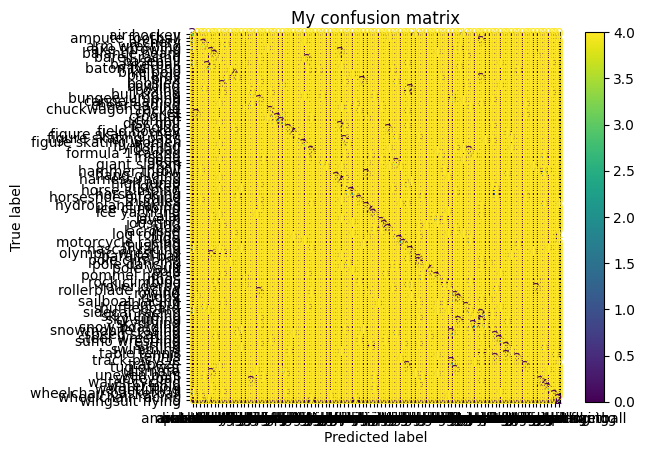

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

plt.figure(figsize=(400,400))
cm = confusion_matrix(labels, predicts)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tuple(classes.values()))
disp.plot()
plt.title("My confusion matrix")
plt.show()